# Predicting Copper Recovery: A Deep Learning Approach

### Importin Essential Packages

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import keras_tuner as kt

In [30]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Dataset Loading

In [3]:
data = pd.read_csv('curec_data.csv')
data.head()

,X,Y,Z,CUCN,CUS,CU,ZONE,CUREC,BN
0,595.0,645.0,15.0,0.0282,0.0168,0.7642,1,85.325005,0.0089
1,600.0,645.0,15.0,0.0285,0.0173,0.7366,1,85.325005,0.0089
2,605.0,645.0,15.0,0.0299,0.0187,0.7116,1,85.617981,0.0091
3,610.0,645.0,15.0,0.0303,0.0190,0.6862,1,85.617981,0.0091
4,615.0,645.0,15.0,0.0333,0.0193,0.7000,1,85.617981,0.0091


### Visual inspection of the data
#### Zone = 0 for secondary ore zone
#### Zone = 1 for primary ore zone

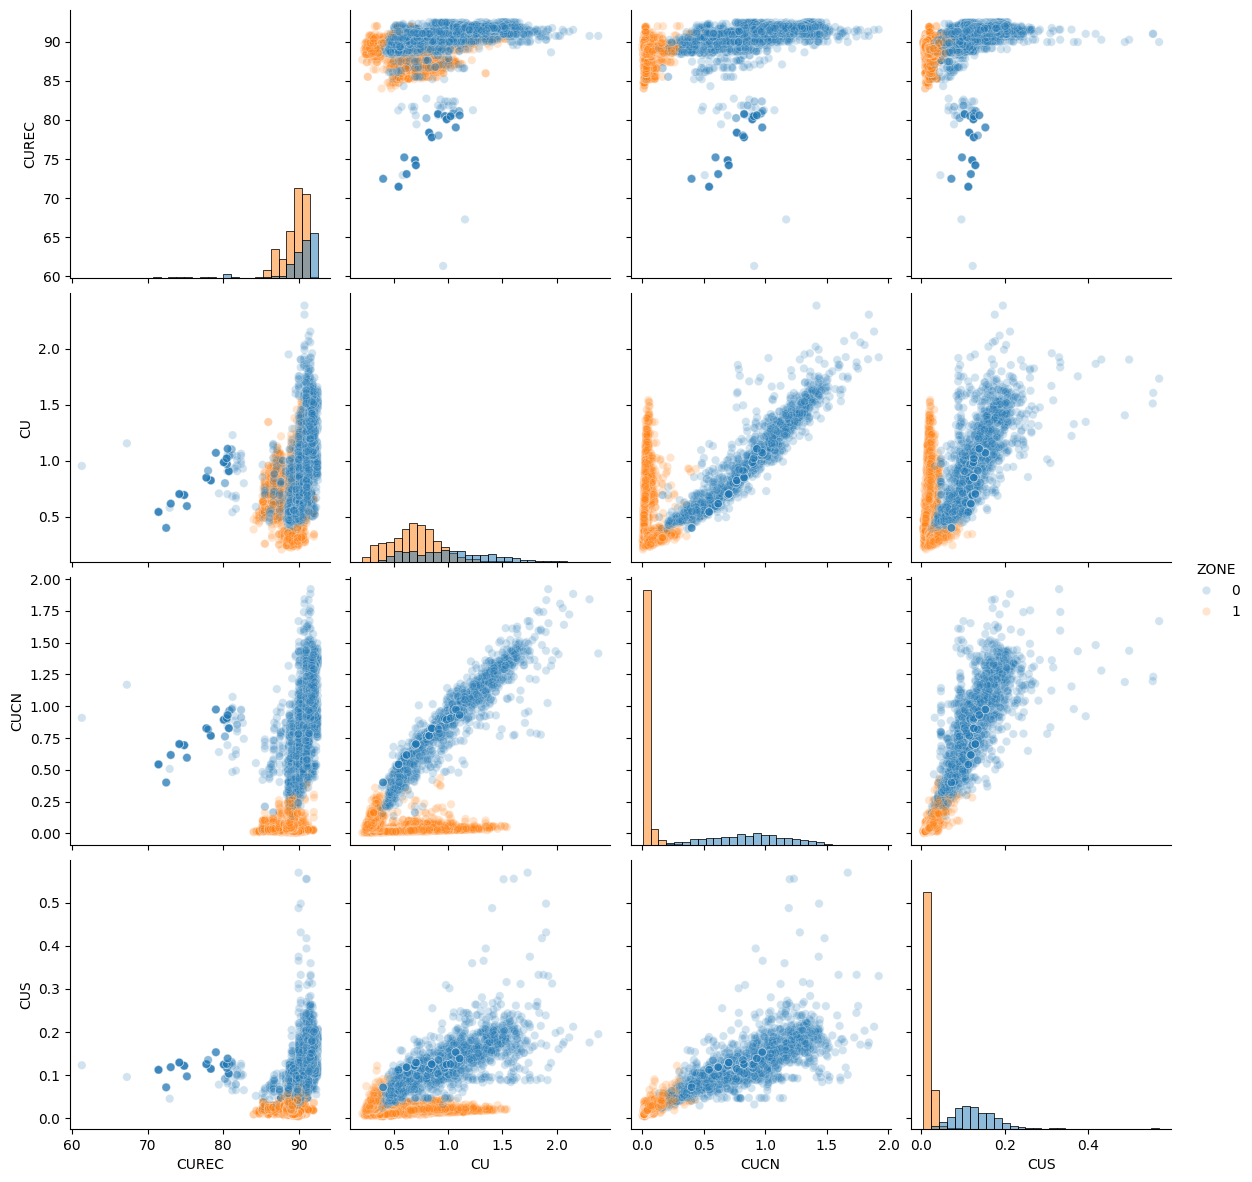

In [4]:
n_samples_to_plot = 5000
columns = ["CUREC", "CU", "CUCN", "CUS"]
_ = sns.pairplot(
    data=data[:n_samples_to_plot],
    vars=columns,
    hue="ZONE",
    plot_kws={"alpha": 0.2},
    height=3,
    diag_kind="hist",
    diag_kws={"bins": 30},
)

### Exploratory Data Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       115155 non-null  float64
 1   Y       115155 non-null  float64
 2   Z       115155 non-null  float64
 3   CUCN    115155 non-null  float64
 4   CUS     115155 non-null  float64
 5   CU      115155 non-null  float64
 6   ZONE    115155 non-null  int64  
 7   CUREC   115155 non-null  float64
 8   BN      115155 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 7.9 MB


In [6]:
data.describe()

,X,Y,Z,CUCN,CUS,CU,ZONE,CUREC,BN
count,115155.000000,115155.000000,115155.000000,115155.000000,115155.000000,115155.000000,115155.000000,115155.000000,115155.000000
mean,656.160783,799.802831,127.350137,0.489408,0.087445,0.859804,0.354479,84.074275,0.027275
std,254.084057,346.388076,67.130362,0.453917,0.101907,0.522491,0.478357,8.497762,0.098332
min,0.000000,0.000000,0.000000,-1.000000,0.000000,0.095100,0.000000,-1.000000,-1.000000
25%,505.000000,545.000000,75.000000,0.052600,0.025000,0.529000,0.000000,82.445504,0.010700
50%,650.000000,840.000000,120.000000,0.408100,0.069500,0.748100,0.000000,86.102989,0.029500
75%,810.000000,1080.000000,165.000000,0.779400,0.118600,1.055150,1.000000,88.901001,0.053000
max,1755.000000,1525.000000,270.000000,3.673000,5.000000,5.000000,1.000000,93.622002,0.233100


In [7]:
data[data < 0] = np.nan
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       115155 non-null  float64
 1   Y       115155 non-null  float64
 2   Z       115155 non-null  float64
 3   CUCN    115134 non-null  float64
 4   CUS     115155 non-null  float64
 5   CU      115155 non-null  float64
 6   ZONE    115155 non-null  int64  
 7   CUREC   115010 non-null  float64
 8   BN      114202 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 7.9 MB


In [8]:
data.dropna(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114096 entries, 0 to 115154
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       114096 non-null  float64
 1   Y       114096 non-null  float64
 2   Z       114096 non-null  float64
 3   CUCN    114096 non-null  float64
 4   CUS     114096 non-null  float64
 5   CU      114096 non-null  float64
 6   ZONE    114096 non-null  int64  
 7   CUREC   114096 non-null  float64
 8   BN      114096 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 8.7 MB


In [9]:
data['LOG_CU'] = np.log(data['CU'])
data_pri = data.loc[data['ZONE'] == 1].copy()
data_sec = data.loc[data['ZONE'] == 0].copy()
data_pri.shape, data_sec.shape

((40790, 10), (73306, 10))

In [10]:
def cu_outliers(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(data = df, x = 'LOG_CU', ax = axes[0])
    axes[0].set_title('Row log_cu distribution')
    
    mu = df['LOG_CU'].mean()
    sigma = df['LOG_CU'].std()
    lim_inf = mu - 3 * sigma
    lim_sup = mu + 3 * sigma
    df_fil = df.loc[(df['LOG_CU'] >= lim_inf) & (df['LOG_CU'] <= lim_sup)]

    if df['ZONE'].unique() ==1:
        title = 'primary'
    else:
        title = 'secondary'

    sns.histplot(data = df, x = 'LOG_CU', ax = axes[1])
    axes[1].axvline(x = lim_inf, color = 'g', label = 'lower limit')
    axes[1].axvline(x = lim_sup, color = 'r', label = 'upper limit')
    axes[1].legend(loc = 'upper left')
    axes[1].set_title('Bounded log_cu distribution with limits')
    fig.suptitle(f'Frecuency and threshold for {title} zone', fontsize=16)
    
    plt.show()
    return df_fil

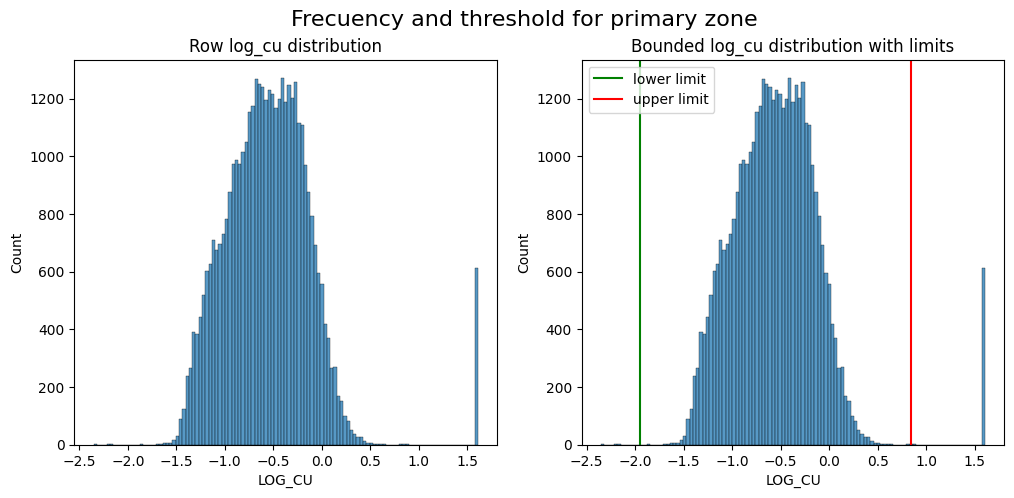

In [11]:
data_pri_fil = cu_outliers(data_pri)

In [12]:
data_pri_fil.head()

,X,Y,Z,CUCN,CUS,CU,ZONE,CUREC,BN,LOG_CU
0,595.0,645.0,15.0,0.0282,0.0168,0.7642,1,85.325005,0.0089,-0.268926
1,600.0,645.0,15.0,0.0285,0.0173,0.7366,1,85.325005,0.0089,-0.305710
2,605.0,645.0,15.0,0.0299,0.0187,0.7116,1,85.617981,0.0091,-0.340239
3,610.0,645.0,15.0,0.0303,0.0190,0.6862,1,85.617981,0.0091,-0.376586
4,615.0,645.0,15.0,0.0333,0.0193,0.7000,1,85.617981,0.0091,-0.356675


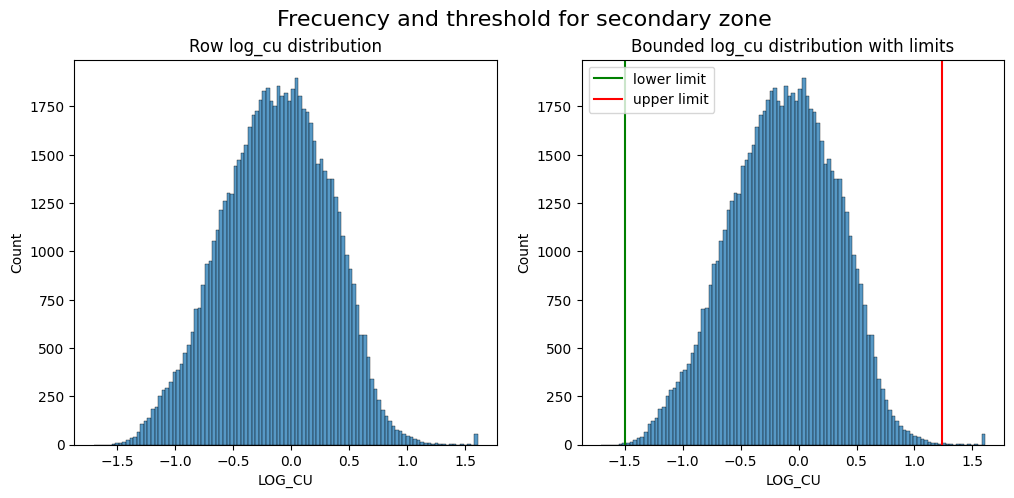

In [13]:
data_sec_fil = cu_outliers(data_sec)

In [14]:
data_sec_fil.head()

,X,Y,Z,CUCN,CUS,CU,ZONE,CUREC,BN,LOG_CU
1881,825.0,870.0,15.0,0.0340,0.0250,0.4880,0,85.289001,0.0284,-0.717440
1882,830.0,870.0,15.0,0.4657,0.0295,0.5399,0,85.468002,0.0283,-0.616371
1958,825.0,875.0,15.0,0.2110,0.0280,0.7650,0,85.510002,0.0300,-0.267879
1959,830.0,875.0,15.0,0.7270,0.0770,1.1430,0,86.613007,0.0356,0.133656
1960,835.0,875.0,15.0,0.5737,0.0604,1.1324,0,86.613007,0.0356,0.124339


<Axes: xlabel='CUREC', ylabel='Count'>

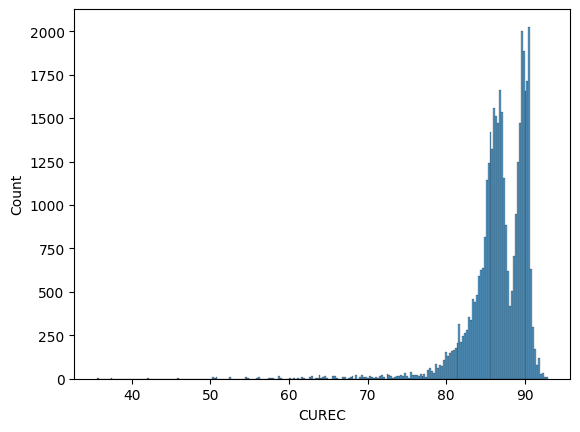

In [15]:
sns.histplot(data=data_pri_fil, x='CUREC')

In [16]:
data_pri_fil = data_pri_fil.loc[data_pri_fil['CUREC'] > 70]
data_pri_fil.shape

(39764, 10)

<Axes: xlabel='CUREC', ylabel='Count'>

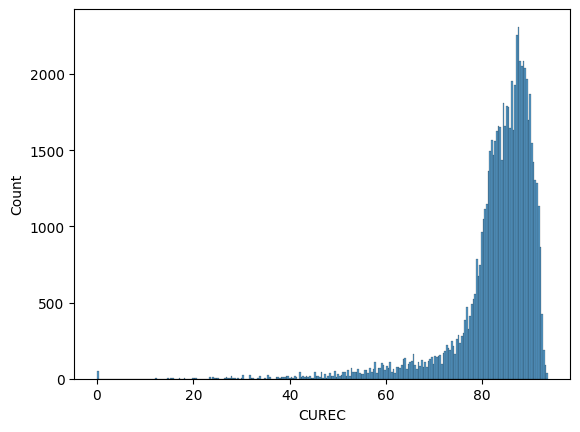

In [17]:
sns.histplot(data=data_sec_fil, x='CUREC')

In [18]:
data_sec_fil = data_sec_fil.loc[data_sec_fil['CUREC'] > 70]
data_sec_fil.shape

(68019, 10)

In [19]:
data = pd.concat([data_pri_fil, data_sec_fil]).reset_index(drop=True)
data.drop(columns = ['LOG_CU'], inplace = True)
data = pd.get_dummies(data, columns=["ZONE"], prefix="ZONE", dtype=int)
data.head()

,X,Y,Z,CUCN,CUS,CU,CUREC,BN,ZONE_0,ZONE_1
0,595.0,645.0,15.0,0.0282,0.0168,0.7642,85.325005,0.0089,0,1
1,600.0,645.0,15.0,0.0285,0.0173,0.7366,85.325005,0.0089,0,1
2,605.0,645.0,15.0,0.0299,0.0187,0.7116,85.617981,0.0091,0,1
3,610.0,645.0,15.0,0.0303,0.0190,0.6862,85.617981,0.0091,0,1
4,615.0,645.0,15.0,0.0333,0.0193,0.7000,85.617981,0.0091,0,1


### Data Splitting & Training the Neural Netwotk

In [20]:
x = data.drop(columns=["CUREC"])
y = data[["CUREC"]] 

In [21]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
fold_no = 1
test_loss_per_fold = []
train_loss_per_fold = []
test_mae_per_fold = []
train_mae_per_fold = []

In [22]:
for train, test in cv.split(x, y):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    x_train = x.iloc[train]
    y_train = y.iloc[train]
    x_test = x.iloc [test]
    y_test = y.iloc [test]
    
    scaler_x.fit(x_train)
    scaler_y.fit(y_train)
    x_train = scaler_x.transform(x_train)
    x_test = scaler_x.transform(x_test)
    y_train = scaler_y.transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    model = Sequential()
    model.add(Dense(50, input_dim = 9, activation = 'relu', kernel_initializer = 'he_normal', bias_initializer = 'zeros' ))
    model.add(Dense(100, activation = 'relu', kernel_initializer = 'he_normal', bias_initializer = 'zeros' ))
    model.add(Dense(100, activation = 'relu', kernel_initializer = 'he_normal', bias_initializer = 'zeros' ))
    model.add(Dense(100, activation = 'relu', kernel_initializer = 'he_normal', bias_initializer = 'zeros' ))
    model.add(Dense(50, activation = 'relu', kernel_initializer = 'he_normal', bias_initializer = 'zeros' ))
    model.add(Dense(1, activation = 'linear', kernel_initializer = 'glorot_normal', bias_initializer = 'zeros' ))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), verbose = 0)

    model.save('models/model_fold_' + str(fold_no)  + '.keras')

    test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)
    train_loss, train_mae = model.evaluate(x_train, y_train, verbose=0)
    test_loss_per_fold.append(test_loss)
    test_mae_per_fold.append(test_mae)
    train_loss_per_fold.append(train_loss)
    train_mae_per_fold.append(train_mae)

    fold_no = fold_no + 1   

### Network Structure: A Graphical Overview

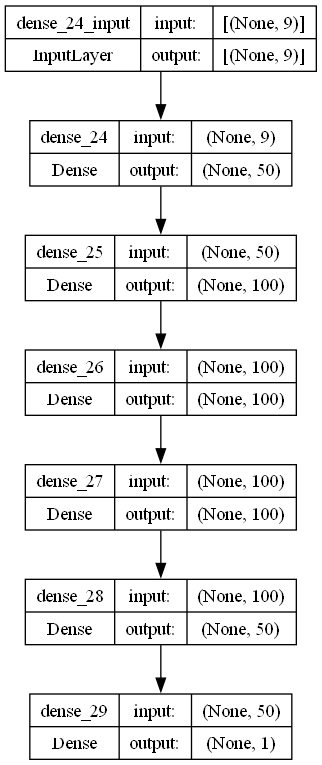

In [23]:
plot_model(
    model, 
    to_file="model_plot.png",  
    show_shapes=True,         
    show_layer_names=True 
)

### Results & Insights from Copper Recovery Predictions

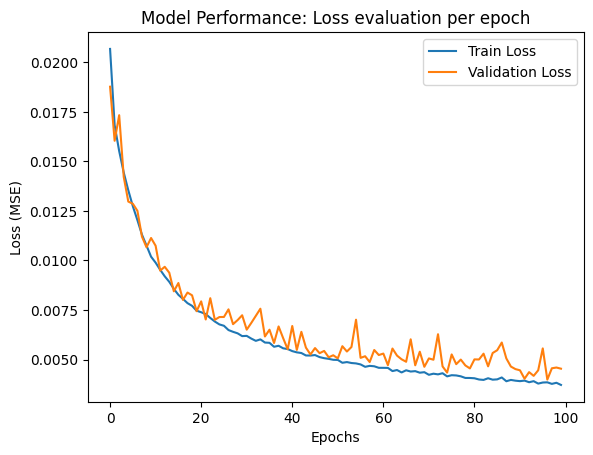

In [24]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Model Performance: Loss evaluation per epoch')
plt.show()

In [25]:
y_pred = model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)
r2 = r2_score(y_test, y_pred)
print(f"R-Squared: {r2}")

674/674 [==============================] - 1s 1ms/step
R-Squared: 0.8628137487048309


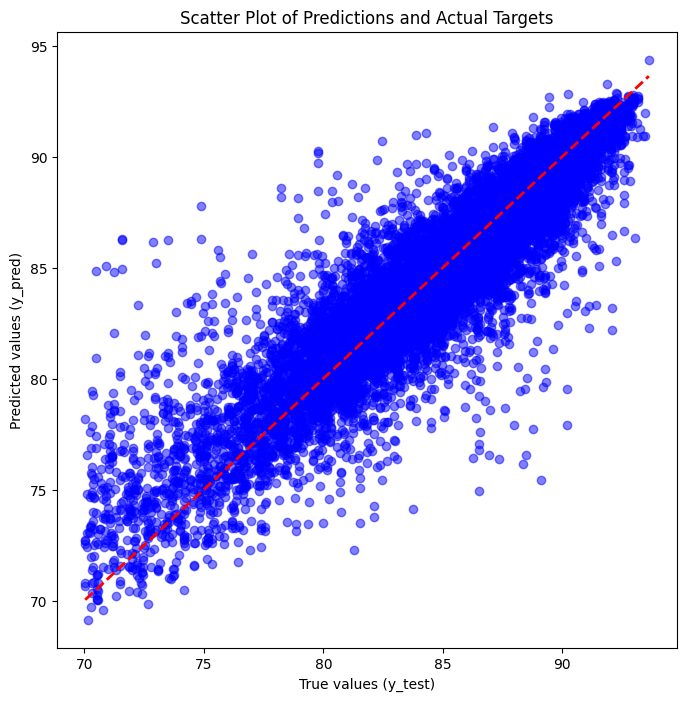

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("True values (y_test)")
plt.ylabel("Predicted values (y_pred)")
plt.title("Scatter Plot of Predictions and Actual Targets")
plt.show()

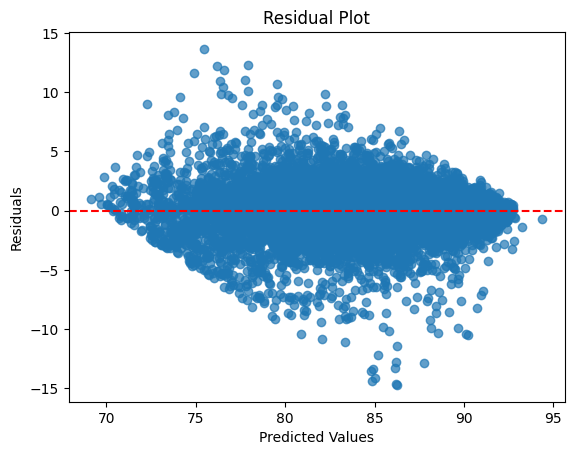

In [27]:
residuals = y_test.flatten() - y_pred.flatten()  

plt.scatter(y_pred, residuals, alpha=0.7)  
plt.axhline(y=0, color='red', linestyle='--')  
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [28]:
df = pd.DataFrame({'test_loss': test_loss_per_fold,
                   'train_loss': train_loss_per_fold,
                 'test_mae': test_mae_per_fold,
                  'train_mae': train_mae_per_fold})
df

,test_loss,train_loss,test_mae,train_mae
0,0.004214,0.003360,0.041466,0.038322
1,0.004265,0.003257,0.041806,0.037798
2,0.004258,0.003457,0.041502,0.038255
3,0.004429,0.003659,0.042736,0.039711
4,0.004543,0.003741,0.043938,0.040802


In [29]:
print(f"The model achieves a Mean Squared Error (MSE) of {df['test_loss'].mean():.4f} ± {df['test_loss'].std():.4f} "
      f"and a Mean Absolute Error (MAE) of {df['test_mae'].mean():.3f} ± {df['test_mae'].std():.3f} on the test set. Demonstrating consistent performance across evaluation metrics")

The model achieves a Mean Squared Error (MSE) of 0.0043 ± 0.0001 and a Mean Absolute Error (MAE) of 0.042 ± 0.001 on the test set. Demonstrating consistent performance across evaluation metrics
